The goal is to build a neural network using PyTorch to estimate the cost of a New York City cab ride from several inputs. The training dataset is based on <a href='https://www.kaggle.com/c/new-york-city-taxi-fare-prediction'>this Kaggle competition</a>. The original dataset contains 55 million records about the pickup date & time, the latitude & longitude (GPS coordinates) of the pickup and dropoff locations, and the number of passengers. For the exercise a randomized sample of 120000 records from April 11 to April 24, 2010 was used.

In [5]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# load dataset
df = pd.read_csv('./NYCTaxiFares.csv')
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1


In [3]:
df['fare_amount'].describe()

count    120000.000000
mean         10.040326
std           7.500134
min           2.500000
25%           5.700000
50%           7.700000
75%          11.300000
max          49.900000
Name: fare_amount, dtype: float64

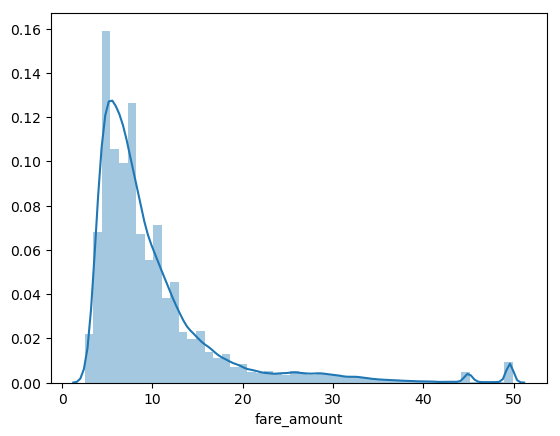

In [7]:
# fares range from $2.50 to $49.90, with a mean of $10.04 and a median of $7.70
sns.distplot(df['fare_amount'])

In [8]:
# use haversine formula to calculate the distance between GPS coordinates
def haversine_distance(df, lat1, long1, lat2, long2):
    r = 6371  # average radius of Earth in kilometers
       
    phi1 = np.radians(df[lat1])
    phi2 = np.radians(df[lat2])
    
    delta_phi = np.radians(df[lat2]-df[lat1])
    delta_lambda = np.radians(df[long2]-df[long1])
     
    a = np.sin(delta_phi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = (r * c) # in kilometers

    return d

In [9]:
df['dist_km'] = haversine_distance(df,'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude')
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321


In [10]:
# parse date column to convert to EDT and get information about exact date and time of each ride
df['EDTdate'] = pd.to_datetime(df['pickup_datetime'].str[:19]) - pd.Timedelta(hours=4)
df['Hour'] = df['EDTdate'].dt.hour
df['AMorPM'] = np.where(df['Hour']<12,'am','pm')
df['Weekday'] = df['EDTdate'].dt.strftime("%a")
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km,EDTdate,Hour,AMorPM,Weekday
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312,2010-04-19 04:17:56,4,am,Mon
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307,2010-04-17 11:43:53,11,am,Sat
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763,2010-04-17 07:23:26,7,am,Sat
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129,2010-04-11 17:25:03,17,pm,Sun
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321,2010-04-16 22:19:01,22,pm,Fri


In [11]:
df['EDTdate'].min()

Timestamp('2010-04-11 00:00:10')

In [12]:
df['EDTdate'].max()

Timestamp('2010-04-24 23:59:42')

In [14]:
# separate categorical from continuous columns
df.columns

Index(['pickup_datetime', 'fare_amount', 'fare_class', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'dist_km', 'EDTdate', 'Hour', 'AMorPM', 'Weekday'],
      dtype='object')

In [15]:
ctg_cols = ['Hour', 'AMorPM', 'Weekday']
cont_cols = ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 'passenger_count', 'dist_km']
y_col = ['fare_amount']  # label column

In [17]:
# convert our three categorical columns to category dtypes
for category in ctg_cols:
    df[category] = df[category].astype('category')

In [18]:
df.dtypes

pickup_datetime              object
fare_amount                 float64
fare_class                    int64
pickup_longitude            float64
pickup_latitude             float64
dropoff_longitude           float64
dropoff_latitude            float64
passenger_count               int64
dist_km                     float64
EDTdate              datetime64[ns]
Hour                       category
AMorPM                     category
Weekday                    category
dtype: object

In [19]:
df['AMorPM'].cat.categories

Index(['am', 'pm'], dtype='object')

In [20]:
df['AMorPM'].head().cat.codes

0    0
1    0
2    0
3    1
4    1
dtype: int8

In [21]:
df['AMorPM'].head()

0    am
1    am
2    am
3    pm
4    pm
Name: AMorPM, dtype: category
Categories (2, object): ['am', 'pm']

In [22]:
# combine categorical columns into one input array using numpy.stack 
hr = df['Hour'].cat.codes.values
ampm = df['AMorPM'].cat.codes.values
wkdy = df['Weekday'].cat.codes.values

ctgs = np.stack([hr, ampm, wkdy], 1)

ctgs[:5]

array([[ 4,  0,  1],
       [11,  0,  2],
       [ 7,  0,  2],
       [17,  1,  3],
       [22,  1,  0]], dtype=int8)

In [23]:
# convert categorical variables to a tensor
ctgs = torch.tensor(ctgs, dtype=torch.int64)
ctgs[:5]

tensor([[ 4,  0,  1],
        [11,  0,  2],
        [ 7,  0,  2],
        [17,  1,  3],
        [22,  1,  0]])

In [24]:
# convert continuous variables to a tensor
conts = np.stack([df[col].values for col in cont_cols], 1)
conts = torch.tensor(conts, dtype=torch.float)
conts[:5]

tensor([[ 40.7305, -73.9924,  40.7447, -73.9755,   1.0000,   2.1263],
        [ 40.7406, -73.9901,  40.7441, -73.9742,   1.0000,   1.3923],
        [ 40.7511, -73.9941,  40.7662, -73.9601,   2.0000,   3.3268],
        [ 40.7564, -73.9905,  40.7482, -73.9712,   1.0000,   1.8641],
        [ 40.7342, -73.9910,  40.7431, -73.9060,   1.0000,   7.2313]])

In [25]:
conts.type()

'torch.FloatTensor'

In [26]:
# convert labels to a tensor
y = torch.tensor(df[y_col].values, dtype=torch.float).reshape(-1,1)
y[:5]

tensor([[ 6.5000],
        [ 6.9000],
        [10.1000],
        [ 8.9000],
        [19.7000]])

In [27]:
ctgs.shape

torch.Size([120000, 3])

In [28]:
conts.shape

torch.Size([120000, 6])

In [29]:
y.shape

torch.Size([120000, 1])

In [30]:
# set embedding sizes for Hours, AMvsPM and Weekdays
ctg_sizes = [len(df[col].cat.categories) for col in ctg_cols]
emb_sizes = [(size, min(50, (size+1)//2)) for size in ctg_sizes]
emb_sizes

[(24, 12), (2, 1), (7, 4)]

In [31]:
# define tabular model
class TabularModel(nn.Module):

    def __init__(self, emb_sizes, n_cont, out_size, layers, p=0.5):
        super().__init__()
        # set up the embedded layers
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_sizes])
        
        # set up a dropout function for the embeddings 
        self.emb_drop = nn.Dropout(p)
        
        # set up a normalization function for the continuous variables
        self.bn_cont = nn.BatchNorm1d(n_cont)
        
        # set up a sequence of neural network layers with a Linear function, activation function,
        # normalization step, and a dropout layer
        layerlist = []
        n_emb = sum((nf for ni,nf in emb_sizes))
        n_in = n_emb + n_cont
        
        for i in layers:
            layerlist.append(nn.Linear(n_in,i)) 
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        layerlist.append(nn.Linear(layers[-1],out_size))
            
        self.layers = nn.Sequential(*layerlist)
    
    def forward(self, x_cat, x_cont):
        # preprocess the embeddings and normalize the continuous variables before passing them through the layers
        embeddings = []
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.emb_drop(x)
        
        x_cont = self.bn_cont(x_cont)
        # combine multiple tensors into one
        x = torch.cat([x, x_cont], 1)
        x = self.layers(x)
        return x

In [32]:
model = TabularModel(emb_sizes, conts.shape[1], 1, [200,100], p=0.4)
model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(24, 12)
    (1): Embedding(2, 1)
    (2): Embedding(7, 4)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=23, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=100, out_features=1, bias=True)
  )
)

In [33]:
# define loss function and optimizer
criterion = nn.MSELoss()  # convert this to RMSE later
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [34]:
# train-test split
batch_size = 60000
test_size = int(batch_size * .2)

ctg_train = ctgs[:batch_size-test_size]
ctg_test = ctgs[batch_size-test_size:batch_size]
con_train = conts[:batch_size-test_size]
con_test = conts[batch_size-test_size:batch_size]
y_train = y[:batch_size-test_size]
y_test = y[batch_size-test_size:batch_size]

In [36]:
len(ctg_train)

48000

In [37]:
len(ctg_test)

12000

In [39]:
# train the model
import time
start_time = time.time()

epochs = 300
losses = []

for i in range(epochs):
    i+=1
    y_pred = model(ctg_train, con_train)
    loss = torch.sqrt(criterion(y_pred, y_train)) # RMSE
    losses.append(loss)

    if i%25 == 1:
        print(f'epoch: {i:3}  loss: {loss.item():10.8f}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print(f'epoch: {i:3}  loss: {loss.item():10.8f}') # print the last line
print(f'\nDuration: {time.time() - start_time:.0f} seconds')

epoch:   1  loss: 12.37608051
epoch:  26  loss: 10.68021965
epoch:  51  loss: 10.07067394
epoch:  76  loss: 9.65267563
epoch: 101  loss: 9.14030933
epoch: 126  loss: 8.40901089
epoch: 151  loss: 7.44466686
epoch: 176  loss: 6.28330421
epoch: 201  loss: 5.09439945
epoch: 226  loss: 4.18441534
epoch: 251  loss: 3.81645584
epoch: 276  loss: 3.71091127
epoch: 300  loss: 3.69140863

Duration: 136 seconds


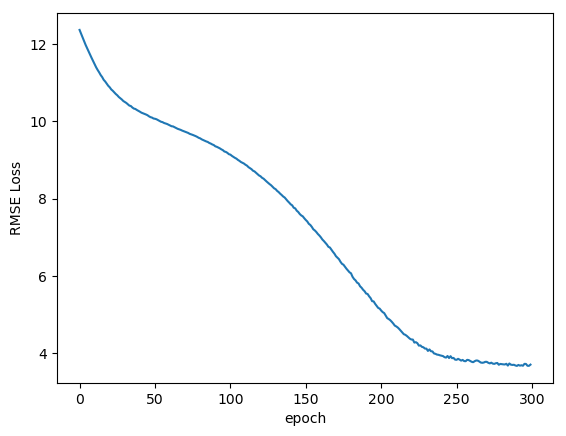

In [41]:
# plot the loss function
plt.plot(range(epochs), [i.item() for i in losses])
plt.ylabel('RMSE Loss')
plt.xlabel('epoch');

In [43]:
# evaluate the test set
with torch.no_grad():
    y_val = model(ctg_test, con_test)
    loss = torch.sqrt(criterion(y_val, y_test))
print(f'RMSE: {loss:.8f}')
# this means that on average, predicted values are within ±$3.31 of the actual value

RMSE: 3.64288926


In [44]:
# take a look at the first 50 predicted values
print(f'{"PREDICTED":>12} {"ACTUAL":>8} {"DIFF":>8}')
for i in range(50):
    diff = np.abs(y_val[i].item()-y_test[i].item())
    print(f'{i+1:2}. {y_val[i].item():8.4f} {y_test[i].item():8.4f} {diff:8.4f}')

   PREDICTED   ACTUAL     DIFF
 1.   2.0118   2.9000   0.8882
 2.  24.1948   5.7000  18.4948
 3.   6.3805   7.7000   1.3195
 4.  11.8140  12.5000   0.6860
 5.   0.7615   4.1000   3.3385
 6.   4.7441   5.3000   0.5559
 7.   1.4720   3.7000   2.2280
 8.  16.2266  14.5000   1.7266
 9.   6.1262   5.7000   0.4262
10.  12.2534  10.1000   2.1534
11.   2.6599   4.5000   1.8401
12.   4.0538   6.1000   2.0462
13.   6.0045   6.9000   0.8955
14.  14.8388  14.1000   0.7388
15.   3.1146   4.5000   1.3854
16.  38.4527  34.1000   4.3527
17.   1.7330  12.5000  10.7670
18.   6.2502   4.1000   2.1502
19.   8.1045   8.5000   0.3955
20.   6.0112   5.3000   0.7112
21.  15.4678  11.3000   4.1678
22.  11.2470  10.5000   0.7470
23.  15.5694  15.3000   0.2694
24.  19.9238  14.9000   5.0238
25.  53.6546  49.5700   4.0846
26.   5.8123   5.3000   0.5123
27.   6.7750   3.7000   3.0750
28.   8.4068   6.5000   1.9068
29.  16.4009  14.1000   2.3009
30.   6.4760   4.9000   1.5760
31.   4.6171   3.7000   0.9171
32.  35.

In [45]:
# test the model with user input
def test_data(mdl):
    # input new data
    plat = float(input('What is the pickup latitude?  '))
    plong = float(input('What is the pickup longitude? '))
    dlat = float(input('What is the dropoff latitude?  '))
    dlong = float(input('What is the dropoff longitude? '))
    psngr = int(input('How many passengers? '))
    dt = input('What is the pickup date and time?\nFormat as YYYY-MM-DD HH:MM:SS     ')
    
    # preprocess the data
    dfx_dict = {'pickup_latitude':plat,'pickup_longitude':plong,'dropoff_latitude':dlat,
         'dropoff_longitude':dlong,'passenger_count':psngr,'EDTdate':dt}
    dfx = pd.DataFrame(dfx_dict, index=[0])
    dfx['dist_km'] = haversine_distance(dfx,'pickup_latitude', 'pickup_longitude',
                                        'dropoff_latitude', 'dropoff_longitude')
    dfx['EDTdate'] = pd.to_datetime(dfx['EDTdate'])
    dfx['Hour'] = dfx['EDTdate'].dt.hour
    dfx['AMorPM'] = np.where(dfx['Hour']<12,0,1) 
    dfx['Weekday'] = dfx['EDTdate'].dt.strftime("%a")
    dfx['Weekday'] = dfx['Weekday'].replace(['Fri','Mon','Sat','Sun','Thu','Tue','Wed'],
                                            [0,1,2,3,4,5,6]).astype('int64')
    # create categorical and continuous tensors
    cat_cols = ['Hour', 'AMorPM', 'Weekday']
    cont_cols = ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude',
                 'dropoff_longitude', 'passenger_count', 'dist_km']
    xcats = np.stack([dfx[col].values for col in cat_cols], 1)
    xcats = torch.tensor(xcats, dtype=torch.int64)
    xconts = np.stack([dfx[col].values for col in cont_cols], 1)
    xconts = torch.tensor(xconts, dtype=torch.float)
    
    # pass new data through the model without backpropagation
    with torch.no_grad():
        z = mdl(xcats, xconts)
    print(f'\nThe predicted fare amount is ${z.item():.2f}')

In [47]:
model.eval()
z = test_data(model)

What is the pickup latitude?  40.5
What is the pickup longitude? -73.9
What is the dropoff latitude?  40.52
What is the dropoff longitude? -73.92
How many passengers? 2
What is the pickup date and time?
Format as YYYY-MM-DD HH:MM:SS     2010-04-15 16:00:00

The predicted fare amount is $17.77
